In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import os

In [4]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [6]:
from sklearn.metrics import classification_report, confusion_matrix


In [7]:
import kagglehub


In [8]:
path = kagglehub.dataset_download("rayhanzamzamy/non-and-biodegradable-waste-dataset")
print("Path to dataset files:", path)


100%|██████████| 1.86G/1.86G [01:25<00:00, 23.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rayhanzamzamy/non-and-biodegradable-waste-dataset/versions/2


In [9]:
train_folders = [os.path.join(path, "TRAIN.1"), os.path.join(path, "TRAIN.2"),
                 os.path.join(path, "TRAIN.3"), os.path.join(path, "TRAIN.4")]
test_folder = os.path.join(path, "TEST")

In [10]:
img_size = (60, 60)
batch_size = 32

In [11]:
def load_datasets(train_folders, test_folder, img_size, batch_size):
    train_datasets = []
    val_datasets = []

    for folder in train_folders:
        train_dataset = image_dataset_from_directory(
            folder,
            label_mode='binary',
            image_size=img_size,
            batch_size=batch_size,
            subset='training',
            validation_split=0.2,
            seed=123  # Ensure consistent split
        )
        val_dataset = image_dataset_from_directory(
            folder,
            label_mode='binary',
            image_size=img_size,
            batch_size=batch_size,
            subset='validation',
            validation_split=0.2,
            seed=123
        )
        train_datasets.append(train_dataset)
        val_datasets.append(val_dataset)

    # Concatenate datasets
    train_dataset = train_datasets[0]
    for ds in train_datasets[1:]:
        train_dataset = train_dataset.concatenate(ds)

    val_dataset = val_datasets[0]
    for ds in val_datasets[1:]:
        val_dataset = val_dataset.concatenate(ds)

    # Test dataset loading
    test_dataset = image_dataset_from_directory(
        test_folder,
        label_mode='binary',
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False
    )
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = load_datasets(train_folders, test_folder, img_size, batch_size)


Found 59922 files belonging to 2 classes.
Using 47938 files for training.
Found 59922 files belonging to 2 classes.
Using 11984 files for validation.
Found 59922 files belonging to 2 classes.
Using 47938 files for training.
Found 59922 files belonging to 2 classes.
Using 11984 files for validation.
Found 59922 files belonging to 2 classes.
Using 47938 files for training.
Found 59922 files belonging to 2 classes.
Using 11984 files for validation.
Found 59924 files belonging to 2 classes.
Using 47940 files for training.
Found 59924 files belonging to 2 classes.
Using 11984 files for validation.
Found 16726 files belonging to 2 classes.


In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer

In [ ]:
model = Sequential()

# Load the VGG16 base model without the top layers
vgg16_base = VGG16(include_top=False, weights="imagenet", input_shape=(60, 60, 3), pooling='max')
for layer in vgg16_base.layers[:15]:  # Freeze first 15 layers
    layer.trainable = False

# Add InputLayer for better shape definition
model.add(InputLayer(input_shape=(60, 60, 3)))  # Use input_shape for compatibility
model.add(vgg16_base)
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification output

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Early Stopping for efficient training
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

# Model Training
epochs = 20

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/20
5996/5996 ━━━━━━━━━━━━━━━━━━━━ 162s 26ms/step - accuracy: 0.9083 - loss: 0.2810 - val_accuracy: 0.9558 - val_loss: 0.1243
Epoch 2/20
5996/5996 ━━━━━━━━━━━━━━━━━━━━ 189s 25ms/step - accuracy: 0.9559 - loss: 0.1192 - val_accuracy: 0.9612 - val_loss: 0.1074
Epoch 3/20
5996/5996 ━━━━━━━━━━━━━━━━━━━━ 147s 25ms/step - accuracy: 0.9679 - loss: 0.0872 - val_accuracy: 0.9608 - val_loss: 0.1159
Epoch 4/20
5996/5996 ━━━━━━━━━━━━━━━━━━━━ 165s 27ms/step - accuracy: 0.9771 - loss: 0.0618 - val_accuracy: 0.9618 - val_loss: 0.1878
Epoch 5/20
5996/5996 ━━━━━━━━━━━━━━━━━━━━ 148s 25ms/step - accuracy: 0.9841 - loss: 0.0431 - val_accuracy: 0.9584 - val_loss: 0.2036
Epoch 6/20
5996/5996 ━━━━━━━━━━━━━━━━━━━━ 146s 24ms/step - accuracy: 0.9895 - loss: 0.0298 - val_accuracy: 0.9605 - val_loss: 0.1763
Epoch 7/20
5996/5996 ━━━━━━━━━━━━━━━━━━━━ 147s 25ms/step - accuracy: 0.9919 - loss: 0.0226 - val_accuracy: 0.9642 - val_loss: 0.1758
Epoch 8/20
5996/5996 ━━━━━━━━━━━━━━━━━━━━ 165s 27ms/step - accuracy: 

523/523 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8695 - loss: 1.4437
Test Accuracy: 0.89
523/523 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step


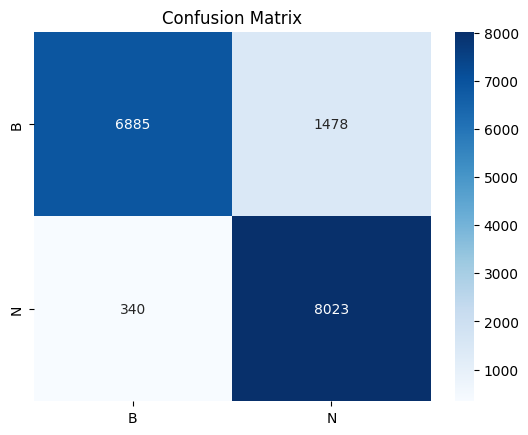

                   precision    recall  f1-score   support

    Biodegradable       0.95      0.82      0.88      8363
Non-Biodegradable       0.84      0.96      0.90      8363

         accuracy                           0.89     16726
        macro avg       0.90      0.89      0.89     16726
     weighted avg       0.90      0.89      0.89     16726



In [ ]:
# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Confusion Matrix and Classification Report
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)
y_pred = np.round(y_pred).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['B', 'N'], yticklabels=['B', 'N'])
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Biodegradable', 'Non-Biodegradable']))


In [ ]:
# Save the model to a .h5 file
model.save('waste_classification_model.h5')


In [ ]:
from google.colab import files
files.download('waste_classification_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
model.save('/content/drive/My Drive/DP/waste_classification_model.h5')


In [ ]:
#from tensorflow.keras.models import load_model

#Load the saved model
#model = load_model('waste_classification_model.h5')
#model = load_model('/content/drive/MyDrive/waste_classification_model.h5')


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_waste_type(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch dimension
    pred_prob = model.predict(img_array)[0][0]
    label = "Biodegradable" if pred_prob < 0.5 else "Non-Biodegradable"
    print(f"Prediction: {label} (Probability: {pred_prob:.2f})")

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

# Function to upload an image
def upload_and_predict():
    # Upload an image file
    uploaded = files.upload()

    # Get the file path of the uploaded image
    img_path = list(uploaded.keys())[0]

    # Use the predict_waste_type function to classify the uploaded image
    predict_waste_type(img_path)

# Now call the upload_and_predict function to upload and classify
upload_and_predict()
